In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')
df.groupby(['mes','ano'], observed=False).agg({'partos_e_nascimentos_qtd': 'sum'}).reset_index()

,mes,ano,partos_e_nascimentos_qtd
0,1,2009,105424.0
1,1,2010,103943.0
2,1,2011,98951.0
3,1,2012,92914.0
4,1,2013,94223.0
...,...,...,...
177,12,2019,80365.0
178,12,2020,75730.0
179,12,2021,78142.0
180,12,2022,75175.0


In [3]:
df['data'] = list(map(lambda x,y: "{}-{}".format(x,y), df['ano'], df['mes']))

In [4]:
def convert_to_datetime(data):
    return datetime.strptime(data, format("%Y-%m"))

In [5]:
df['time'] = list(map(lambda x: convert_to_datetime(x), df['data']))


In [6]:
df_st = df.groupby(['time']).agg({'partos_e_nascimentos_qtd': 'sum',
                                  'partos_e_nascimentos_val':'sum',
                                  'cirurgias_obstetricas_qtd': 'sum',
                                  'cirurgias_obstetricas_val': 'sum'})

In [7]:
df_st = df_st['2009-01-01':'2023-12-01']


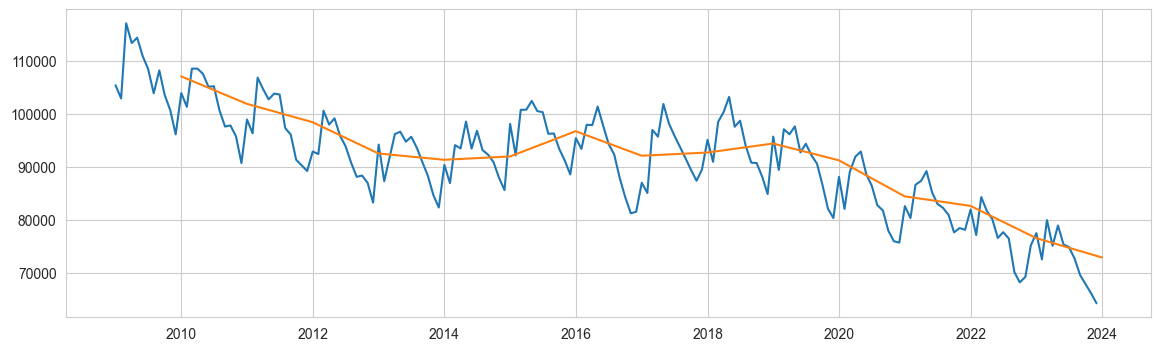

In [25]:
# Compute annual mean 
media_anual = df_st['partos_e_nascimentos_qtd'].resample('A').mean()
media_anual.index.name = 'ano'

plt.figure(figsize=(14, 4))
plt.plot(df_st.partos_e_nascimentos_qtd, label="Qtd")
plt.plot(media_anual, label="Média Anual")
plt.show()

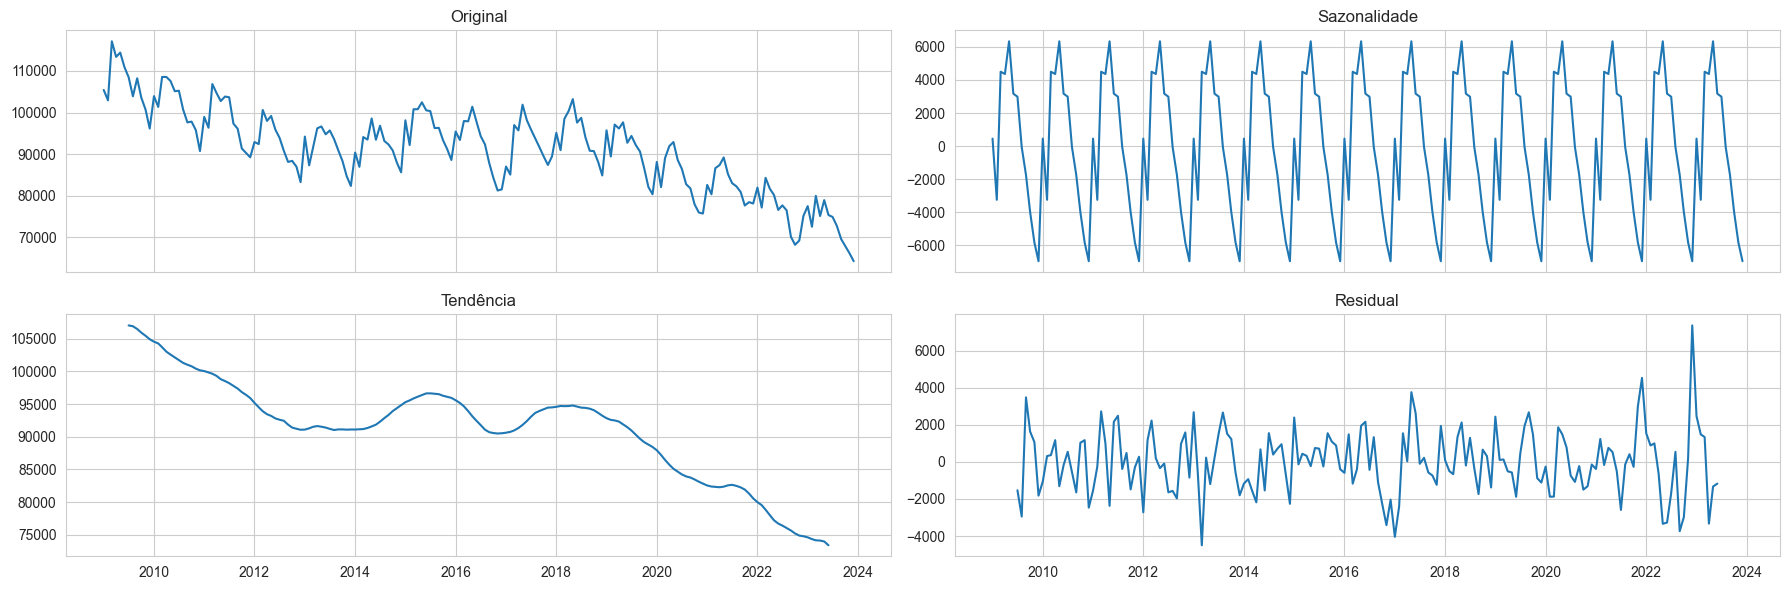

In [23]:
decomposition = seasonal_decompose(x=df_st['partos_e_nascimentos_qtd'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(df_st['partos_e_nascimentos_qtd'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Sazonalidade')
axs[1,0].plot(trend)
axs[1,0].set_title('Tendência')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

In [10]:
df_st.shape

(180, 4)

In [10]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid()

ADF Statistic: -0.20
p-value: 0.938
Critical Values: ['1%: -3.47', '5%: -2.88', '10%: -2.58']



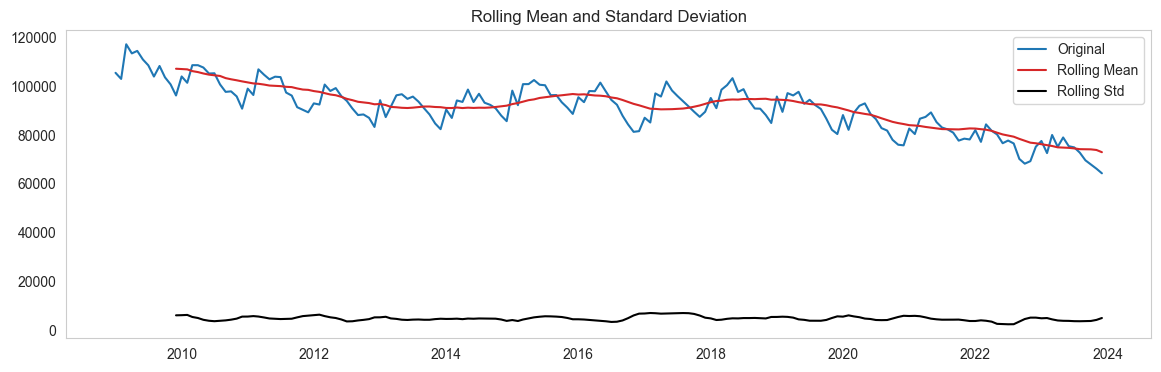

In [11]:
adftest(df_st.partos_e_nascimentos_qtd)

In [27]:
adftest(media_anual, plots=False)

ADF Statistic: -0.34
p-value: 0.920
Critical Values: ['1%: -4.01', '5%: -3.10', '10%: -2.69']



In [28]:
sazonalidade = 12
df_st['sazonal_diff'] = df_st['partos_e_nascimentos_qtd'].diff(sazonalidade)

In [29]:
df_st.dropna(inplace=True)

In [30]:
df_st.isnull().sum()

partos_e_nascimentos_qtd     0
partos_e_nascimentos_val     0
cirurgias_obstetricas_qtd    0
cirurgias_obstetricas_val    0
sazonal_diff                 0
dtype: int64

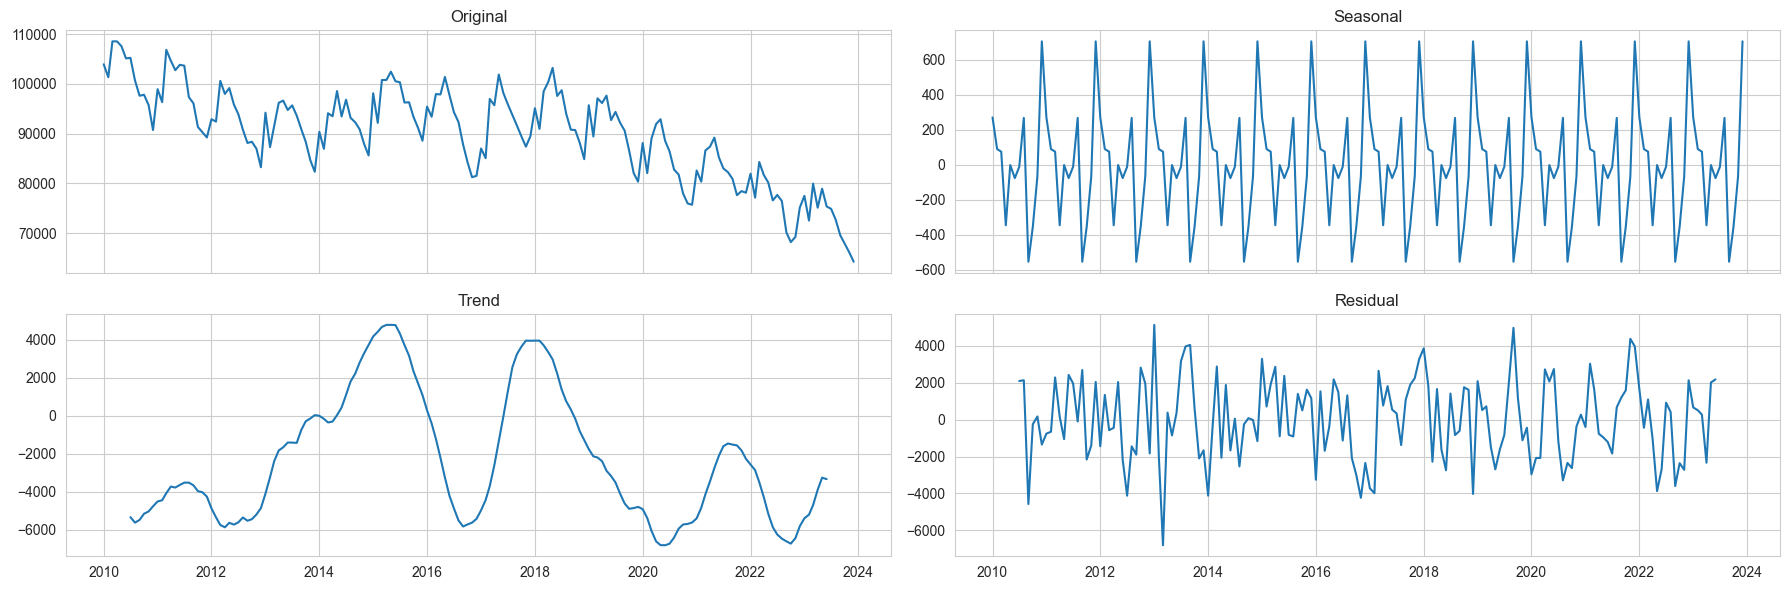

In [31]:
decomposition = seasonal_decompose(x=df_st['sazonal_diff'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(df_st['partos_e_nascimentos_qtd'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

In [33]:
adftest(df_st.sazonal_diff, plots=False)

ADF Statistic: -2.54
p-value: 0.105
Critical Values: ['1%: -3.47', '5%: -2.88', '10%: -2.58']



In [34]:
df_st['sazonal_diff_2'] = df_st['sazonal_diff'].diff(sazonalidade)

In [35]:
df_st.dropna(inplace=True)
df_st.isnull().sum()

partos_e_nascimentos_qtd     0
partos_e_nascimentos_val     0
cirurgias_obstetricas_qtd    0
cirurgias_obstetricas_val    0
sazonal_diff                 0
sazonal_diff_2               0
dtype: int64

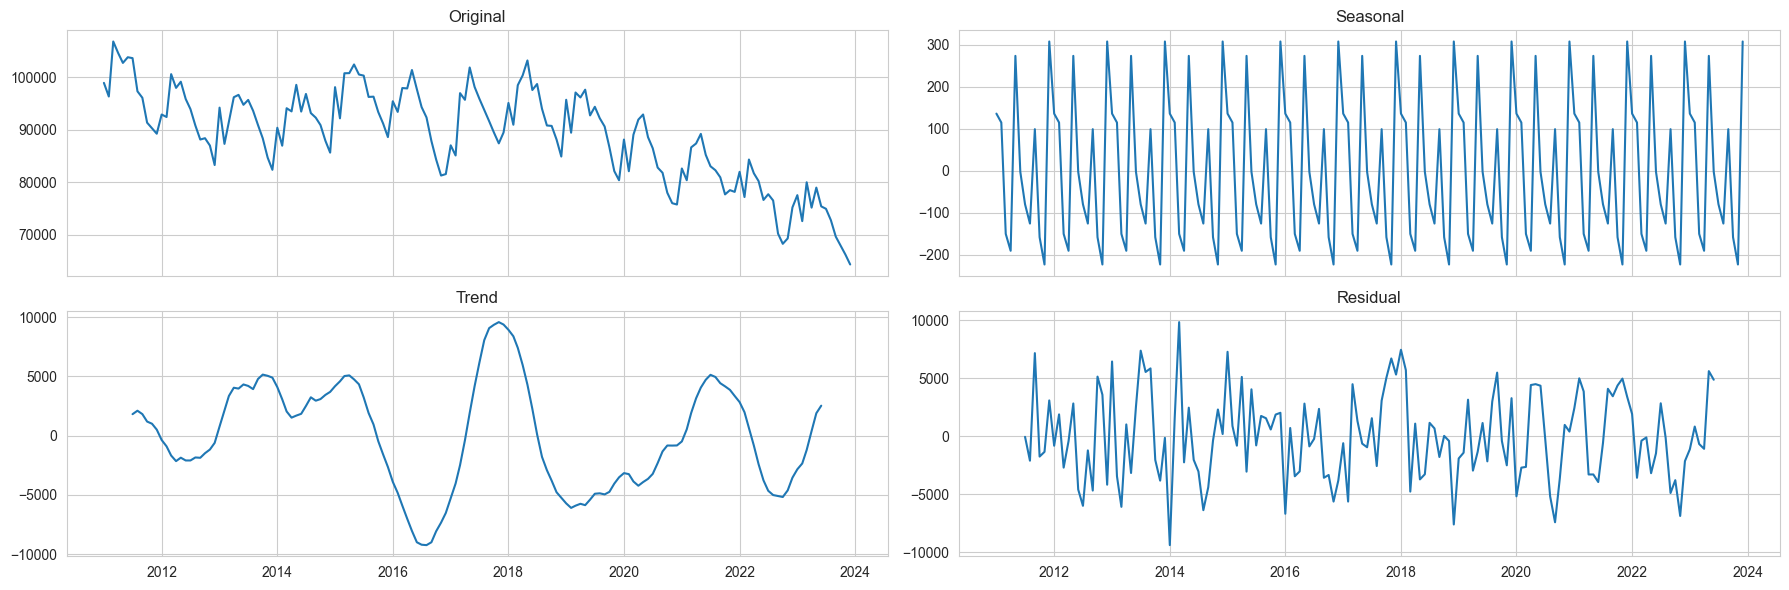

In [36]:
decomposition = seasonal_decompose(x=df_st['sazonal_diff_2'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(df_st['partos_e_nascimentos_qtd'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

ADF Statistic: -3.37
p-value: 0.012
Critical Values: ['1%: -3.48', '5%: -2.88', '10%: -2.58']



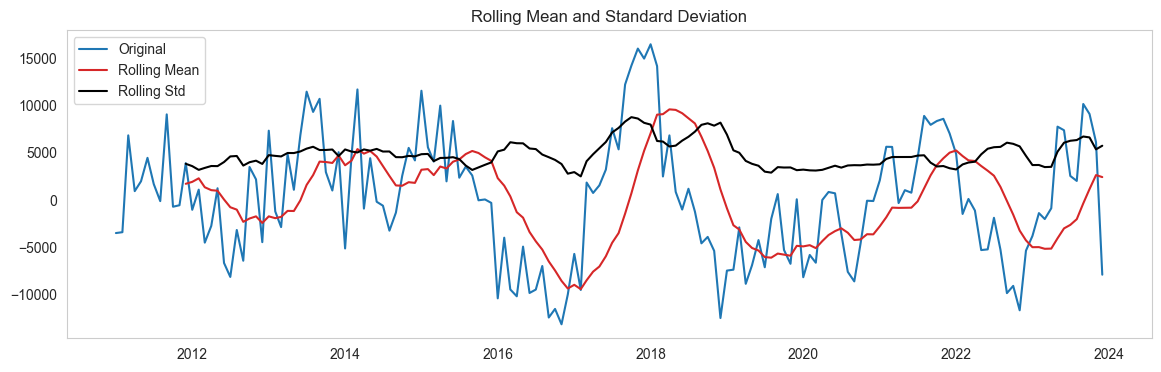

In [39]:
adftest(df_st.sazonal_diff_2)

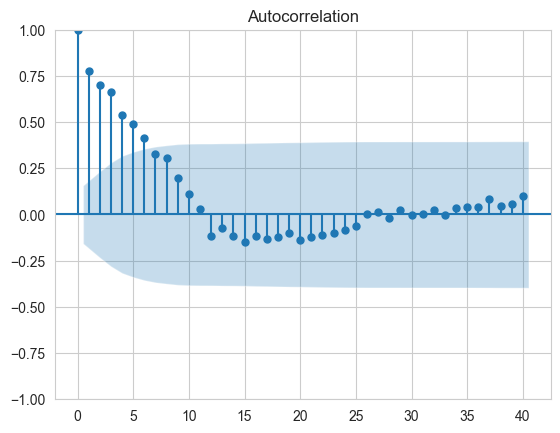

In [49]:
plot_acf(df_st['sazonal_diff'], lags=40)
plt.show()

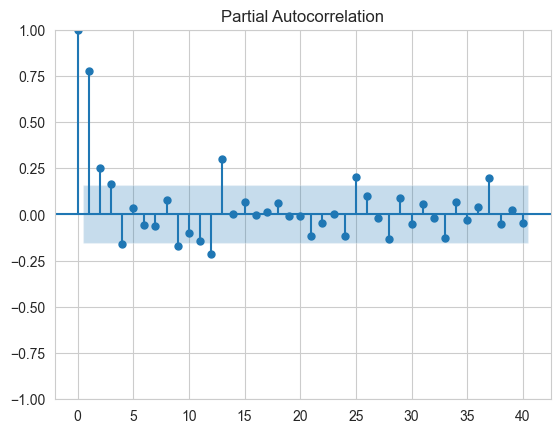

In [50]:
plot_pacf(df_st.sazonal_diff, lags=40)
plt.show()